## B. Topic Modelling : PART-II

This module focuses on the implementation of LDA to identify key topics.

In [1]:
# load required packages/libraries
import os
import time
import math
import re
from pprint import pprint
from textblob import TextBlob
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
import multiprocessing
import string

nltk.download('wordnet')
nltk.download('punkt') 
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

import warnings
warnings.filterwarnings("ignore")

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel



2023-05-26 11:31:44.624902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 11:31:47.249604: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-26 11:31:47.249719: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [2]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [3]:
num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors-1

print(f'Using {workers} workers')

Using 31 workers


In [4]:
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

#### a) Data Extraction

In [5]:
# Load the dataset
news_tm = pd.read_parquet('processed_news_articles.parquet', engine='pyarrow')

# Check the shape of dataset
news_tm.shape

(160842, 9)

In [6]:
# Display a few records
news_tm.head(3)

,url,date,language,title,text,cleaned_text,lemmatized_text,num_tokens,token_bucket
0,http://en.people.cn/n3/2021/0318/c90000-983012...,2021-03-18,en,Artificial intelligence improves parking effic...,\n\nArtificial intelligence improves parking e...,artificial intelligence improves parking effic...,artificial intelligence improves parking effic...,5752,5001-10000
2,http://www.dataweek.co.za/12835r,2021-03-26,en,"Forget ML, AI and Industry 4.0 – obsolescence ...","\n\nForget ML, AI and Industry 4.0 – obsolesce...",forget ml ai industry obsolescence focus febru...,forget ml ai industry obsolescence focus febru...,13520,10001-15000
3,http://www.homeoffice.consumerelectronicsnet.c...,2021-03-10,en,Strategy Analytics: 71% of Smartphones Sold Gl...,\n\nStrategy Analytics: 71% of Smartphones Sol...,strategy analytics smartphones sold globally a...,strategy analytics smartphones sold globally a...,9490,5001-10000


#### b) LDA

In [7]:

lemmatized_news_tokens = [doc.split() for doc in news_tm['lemmatized_text'].tolist()]
%time

# creating the term dictionary of our corpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(lemmatized_news_tokens)

# converting the list of documents (corpus) into a Document Term Matrix using the dictionary prepared above.
doc_term_matrix_news = [dictionary.doc2bow(doc) for doc in lemmatized_news_tokens]


CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 20.5 µs


In [8]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix_news,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized_news_tokens, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence(), lda_model

In [9]:
%time

grid = {}
grid['Validation_Set'] = {}

# topics range
min_topics = 3
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# alpha parameter
alpha = ['symmetric'] # Run for number of topics only

# beta parameter
beta = ['auto'] # Run for number of topics only

# validation sets
num_of_docs = len(doc_term_matrix_news)
corpus_sets = [doc_term_matrix_news]
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')
   
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv, md = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)

        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
lda_tuning_news = pd.DataFrame(model_results)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.2 µs
LDA will execute 13 iterations
Completed model based on 3 LDA topics. Finished 7.7% of LDA runs
Execution time to calculate for topic 3: 0hour:6min:45sec
Completed model based on 4 LDA topics. Finished 15.4% of LDA runs
Execution time to calculate for topic 4: 0hour:7min:2sec
Completed model based on 5 LDA topics. Finished 23.1% of LDA runs
Execution time to calculate for topic 5: 0hour:7min:21sec
Completed model based on 6 LDA topics. Finished 30.8% of LDA runs
Execution time to calculate for topic 6: 0hour:7min:38sec
Completed model based on 7 LDA topics. Finished 38.5% of LDA runs
Execution time to calculate for topic 7: 0hour:7min:51sec
Completed model based on 8 LDA topics. Finished 46.2% of LDA runs
Execution time to calculate for topic 8: 0hour:9min:37sec
Completed model based on 9 LDA topics. Finished 53.8% of LDA runs
Execution time to calculate for topic 9: 0hour:14min:45sec
Completed model based on 10 LDA to

In [10]:
lda_tuning_news.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence
9,12,symmetric,auto,0.421046
2,5,symmetric,auto,0.416999
8,11,symmetric,auto,0.414686
1,4,symmetric,auto,0.413748
3,6,symmetric,auto,0.407478
5,8,symmetric,auto,0.404442
10,13,symmetric,auto,0.402527
11,14,symmetric,auto,0.401604
7,10,symmetric,auto,0.400458
12,15,symmetric,auto,0.397099


In [11]:
lda_tuning_best_news = lda_tuning_news.sort_values(by=['Coherence'], ascending=False).head(1)

tuned_topics_news = int(lda_tuning_best_news['Topics'].to_string(index=False))

# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best_news['Alpha'].to_string(index=False))
except:
    tuned_alpha =lda_tuning_best_news['Alpha'].to_string(index=False).strip()
    

try:
    tuned_beta = float(lda_tuning_best_news['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best_news['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics_news}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 12, Alpha: symmetric, Beta: auto


In [12]:
%time

tuned_lda_model_news = LdaMulticore(corpus=doc_term_matrix_news,
                       id2word=dictionary,
                       num_topics=tuned_topics_news,
                       random_state=100,
                       passes=10,
                       alpha=tuned_alpha,
                       eta=tuned_beta,
                       workers = workers)

coherence_model_lda = CoherenceModel(model=tuned_lda_model_news, texts=lemmatized_news_tokens, dictionary=dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_model_lda)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 11.9 µs

Coherence Score:  Coherence_Measure(seg=<function s_one_set at 0x7fe475b108b0>, prob=<function p_boolean_sliding_window at 0x7fe475b10b80>, conf=<function cosine_similarity at 0x7fe4758f9bd0>, aggr=<function arithmetic_mean at 0x7fe4758fa170>)


In [13]:
%time

lda_display = gensimvis.prepare(tuned_lda_model_news, doc_term_matrix_news, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 11.4 µs


In [20]:
selected_topics = ['Topic1','Topic2','Topic3',
                  'Topic4','Topic5','Topic6',
                  'Topic7','Topic8','Topic9',
                  'Topic10','Topic11','Topic12']
topic_info = lda_display.topic_info
selected_topic_info = topic_info[topic_info.Category.isin(selected_topics)]
terms = selected_topic_info['Term']
frequencies = selected_topic_info['Freq']


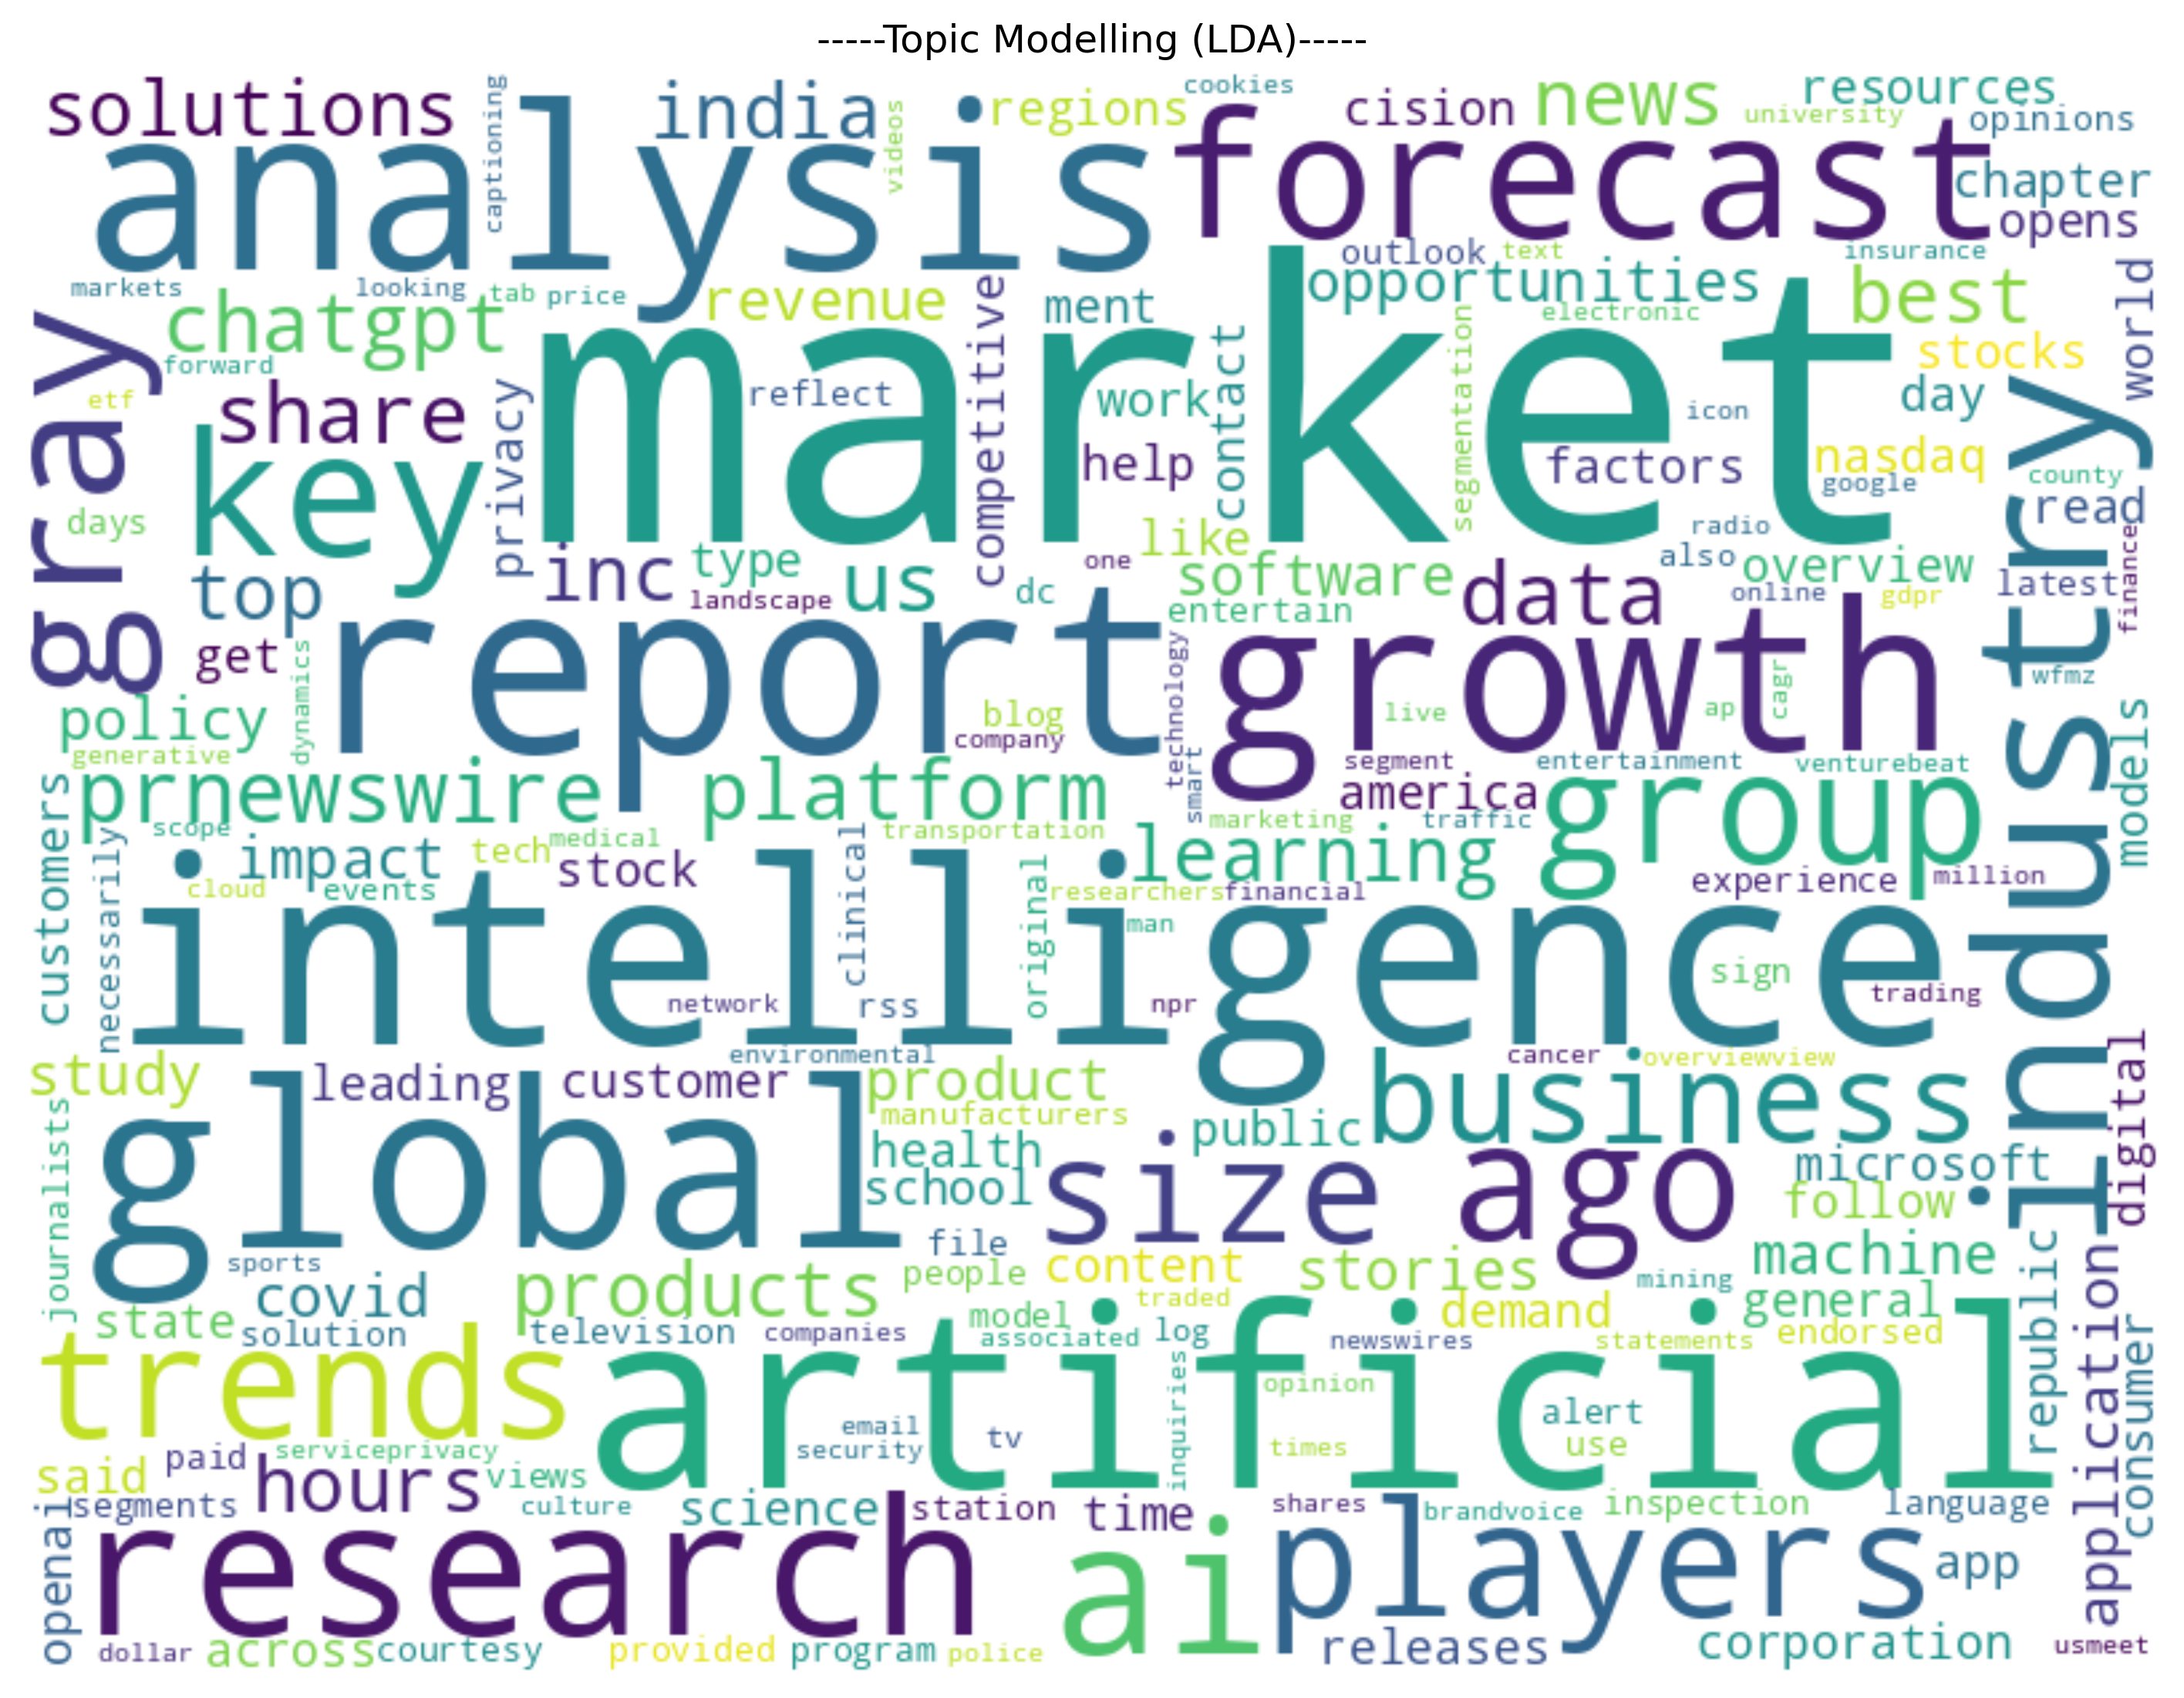

In [24]:
wordcloud_data = dict(zip(terms, frequencies))

# Generate word cloud
wordcloud = WordCloud(background_color='white', width=800, height=600).generate_from_frequencies(wordcloud_data)

# Create a figure and set the DPI
fig = plt.figure(figsize=(12, 9), dpi=300)

# Plot the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("-----Topic Modelling (LDA)-----")
plt.axis('off')

# Show the plot with adjusted DPI
fig.set_dpi(300)
plt.show()


LDA is comparatively very slow than BERTopic, in addition to efficieny. BERTopic gave better results in terms of identifying the related workforce industries.